Importing Libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

Loading Dataset

In [26]:
train_data = os.path.join('./Combined/Train')
test_data = os.path.join('./Combined/Test')

In [27]:
activities = ['LAYING', 'SITTING', 'STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

In [28]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]
for activity in activities:
    folder = os.path.join(train_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(train_data,activity,csv),header=0)
        x_train.append(df.values[:500])
        y_train.append(activity)
for activity in activities:
    folder = os.path.join(test_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(test_data,activity,csv),header=0)
        x_test.append(df.values[:500])
        y_test.append(activity)

In [29]:
x_train=np.array(x_train)
y_train=np.array(y_train)
print(f"Shape of X_train = {x_train.shape}") 
print(f'Shape of y_train = {y_train.shape}')

x_test=np.array(x_test)
y_test=np.array(y_test)
print(f"Shape of X_test = {x_test.shape}")
print(f'Shape of y_test = {y_test.shape}')

Shape of X_train = (126, 500, 3)
Shape of y_train = (126,)
Shape of X_test = (54, 500, 3)
Shape of y_test = (54,)


### Q1 Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data? [0.5 marks]

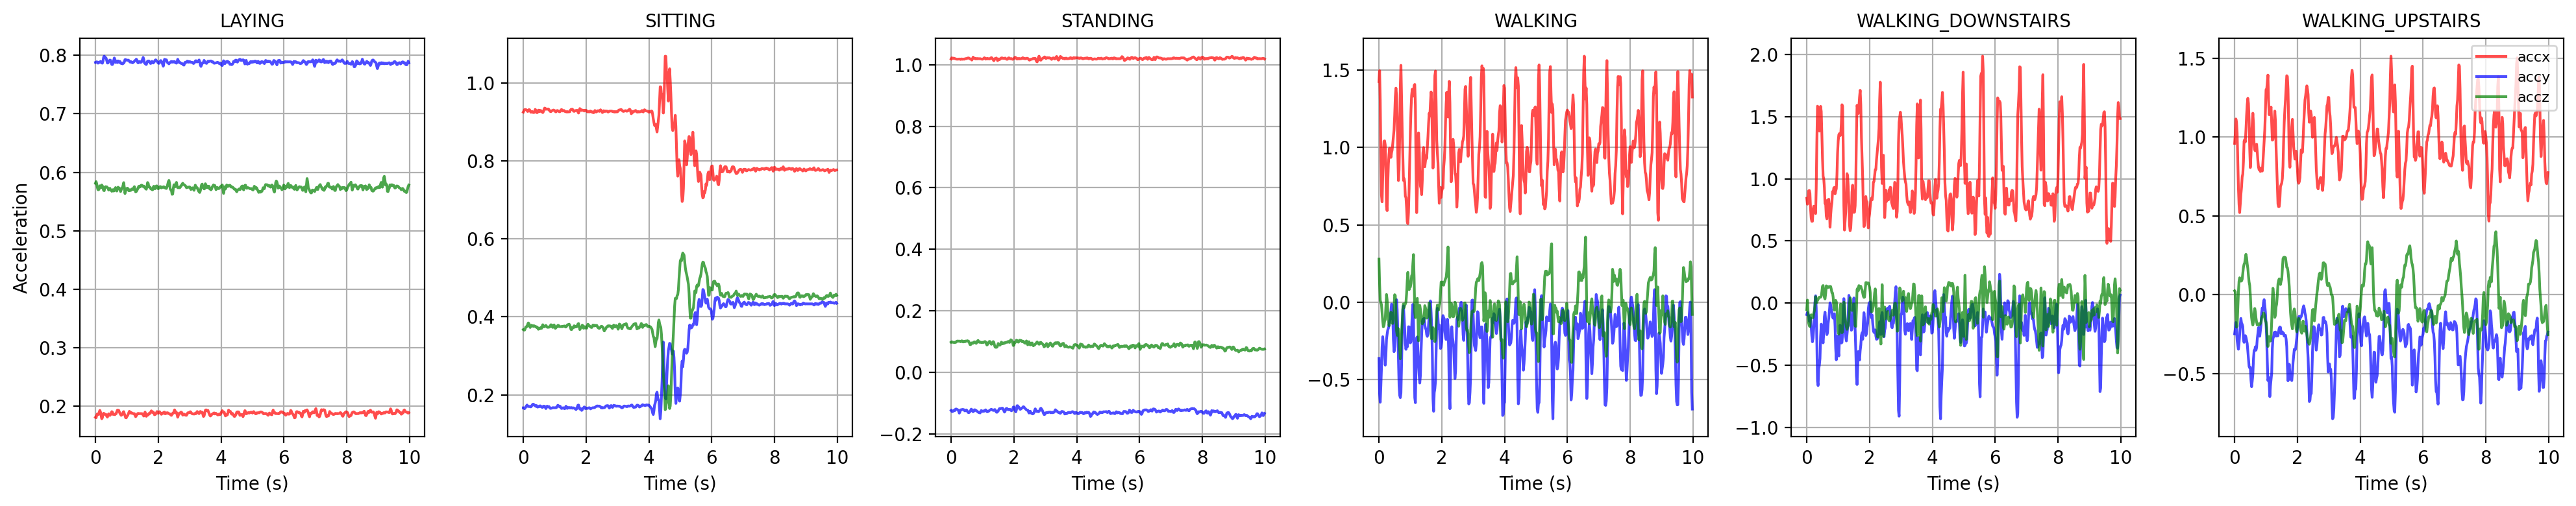

In [56]:
activities = ["LAYING", "SITTING", "STANDING", 
              "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS"]


freq = 50   
n = 500    

plt.figure(figsize=(20, 4))  

for i, activity in enumerate(activities):
    df = pd.read_csv(f"Combined/Train/{activity}/Subject_1.csv").iloc[:n]
    time = np.arange(len(df)) / freq

    plt.subplot(1, 6, i+1)
    plt.plot(time, df["accx"], label="accx", color="r", alpha=0.7)
    plt.plot(time, df["accy"], label="accy", color="b", alpha=0.7)
    plt.plot(time, df["accz"], label="accz", color="g", alpha=0.7)

    plt.title(activity, fontsize=10)
    plt.xlabel("Time (s)")
    if i == 0:  
        plt.ylabel("Acceleration")
    plt.grid(True)
    if i == 5:  
        plt.legend(loc="upper right", fontsize=8)

plt.tight_layout()
plt.show()

The differences/similarities between the various activities are:

The variation in the accelerometer values of static acitivities like laying, sitting, and standing is much less than dynamic activities like walking, walking_upstairs and walking_downstairs.
The accelerometer readings are much different in the static activities (for example, acc x for laying is in the range (0.18,0.19), for sitting (0.7,1.05) and for standing (1.01,1.02) whereas its almost same for dynamic activities (0.6,1.5))


Yes, the model could classify the distinction between static and dynamic activities very clearly. Yet, it may face some difficulty in classifying among the different static and dynamic activities.

### Q2 Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities (walking, walking_downstairs, walking_upstairs)?  
### Look at the linear acceleration:  
\[
a_{mag} = \sqrt{acc_x^2 + acc_y^2 + acc_z^2}
\]
### for each activity and justify your answer. [0.5 marks]

In [31]:
total_acceleration = x_train[:,:,0]**2 + x_train[:,:,1]**2 + x_train[:,:,2]**2
total_acceleration_x_test = x_test[:,:,0]**2 + x_test[:,:,1]**2 + x_test[:,:,2]**2
for i in range(len(activities)):
    activity=activities[i]
    var_ = total_acceleration[i*21].var()
    mean_ = total_acceleration[i*21].mean()
    print(f"Mean total acceleration for activity {activity} = {mean_}")
    print(f"Variance in  total acceleration for activity {activity} = {var_}")

Mean total acceleration for activity LAYING = 0.9860041348456543
Variance in  total acceleration for activity LAYING = 2.8397271960160696e-05
Mean total acceleration for activity SITTING = 1.0155730317634546
Variance in  total acceleration for activity SITTING = 0.0013195388263560468
Mean total acceleration for activity STANDING = 1.0651446745037902
Variance in  total acceleration for activity STANDING = 2.5184611553195693e-05
Mean total acceleration for activity WALKING = 1.1896363025467223
Variance in  total acceleration for activity WALKING = 0.34173146968972834
Mean total acceleration for activity WALKING_DOWNSTAIRS = 1.204763187394195
Variance in  total acceleration for activity WALKING_DOWNSTAIRS = 0.6583017084147446
Mean total acceleration for activity WALKING_UPSTAIRS = 1.1484399512674806
Variance in  total acceleration for activity WALKING_UPSTAIRS = 0.22998141227853178


No, we don't really need a machine learning model to distinguish between static and dynamic activities. We can classify them seperately just be setting some threshold on mean or variance or some other property as these numbers vary to a great extent between static and dynamic activities.

In [32]:
total_acceleration.shape

(126, 500)

In [33]:
total_acceleration_test = x_test[:,:,0]**2 + x_test[:,:,1]**2 + x_test[:,:,2]**2
print(total_acceleration_test.shape)

(54, 500)


### Q3 Visualize the data using PCA. [1 marks]


PCA on Raw Data

In [34]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(total_acceleration)
pca_data = pca.transform(total_acceleration)
pca_data.shape



(126, 2)

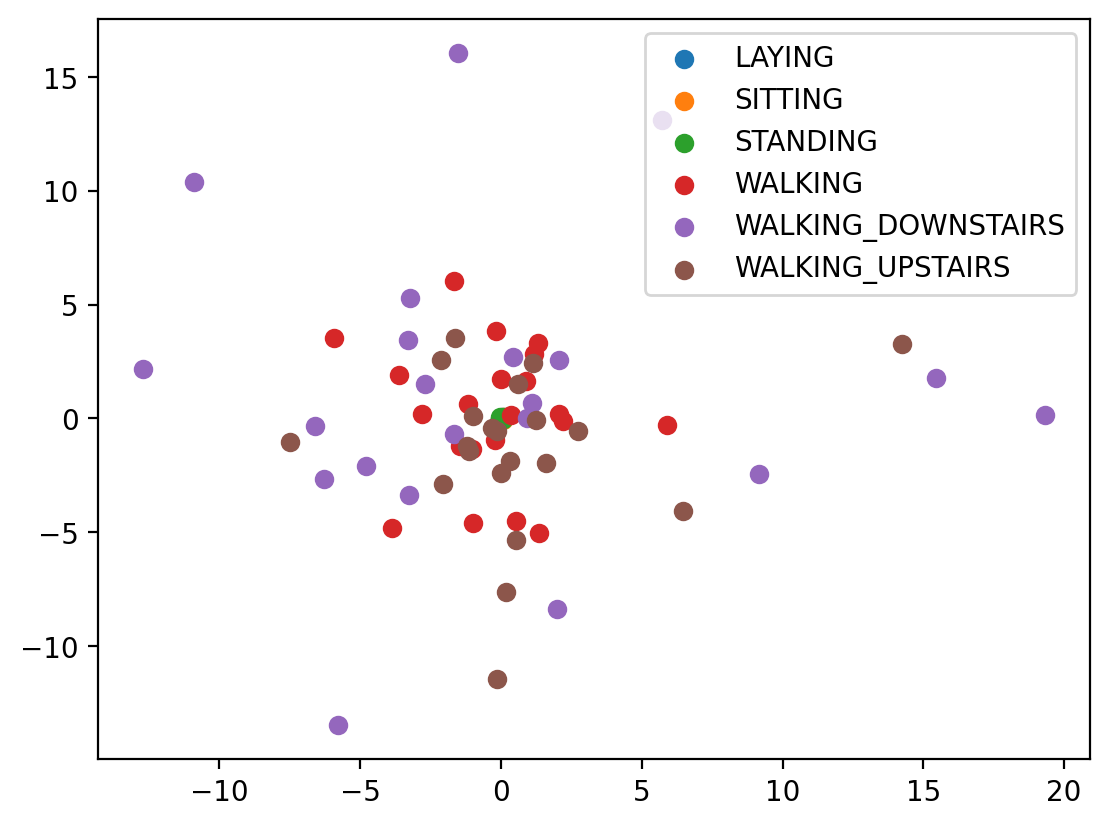

In [35]:
for i in range(len(activities)):
    activity = activities[i]
    plt.scatter(pca_data[i*21:(i+1)*21,0],pca_data[i*21:(i+1)*21,1],label=activity)
    plt.legend()

Featurization using TSFEL

In [36]:
import tsfel
from tsfel.feature_extraction.features import calc_mean, calc_var, pk_pk_distance, mean_abs_deviation, auc, autocorr

In [37]:
def extract_features(data):
    tsfel_features=[]
    for i in range(len(data)):
        mean = calc_mean(data[i])
        var = calc_var(data[i])
        dist = pk_pk_distance(data[i])
        mad = mean_abs_deviation(data[i])
        corr = autocorr(data[i])
        auc_ = auc(data[i],50)
        tsfel_features.append([mean,var,dist,mad,corr,auc_])
    return tsfel_features

In [38]:
tsfel_features_train=np.array(extract_features(total_acceleration))
tsfel_features_test=np.array(extract_features(total_acceleration_test))

In [39]:
print(tsfel_features_train.shape)
print(tsfel_features_test.shape)

(126, 6)
(54, 6)


In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
pca.fit(tsfel_features_train)
tsfel_pca_data = pca.transform(tsfel_features_train)
tsfel_pca_data.shape

(126, 2)

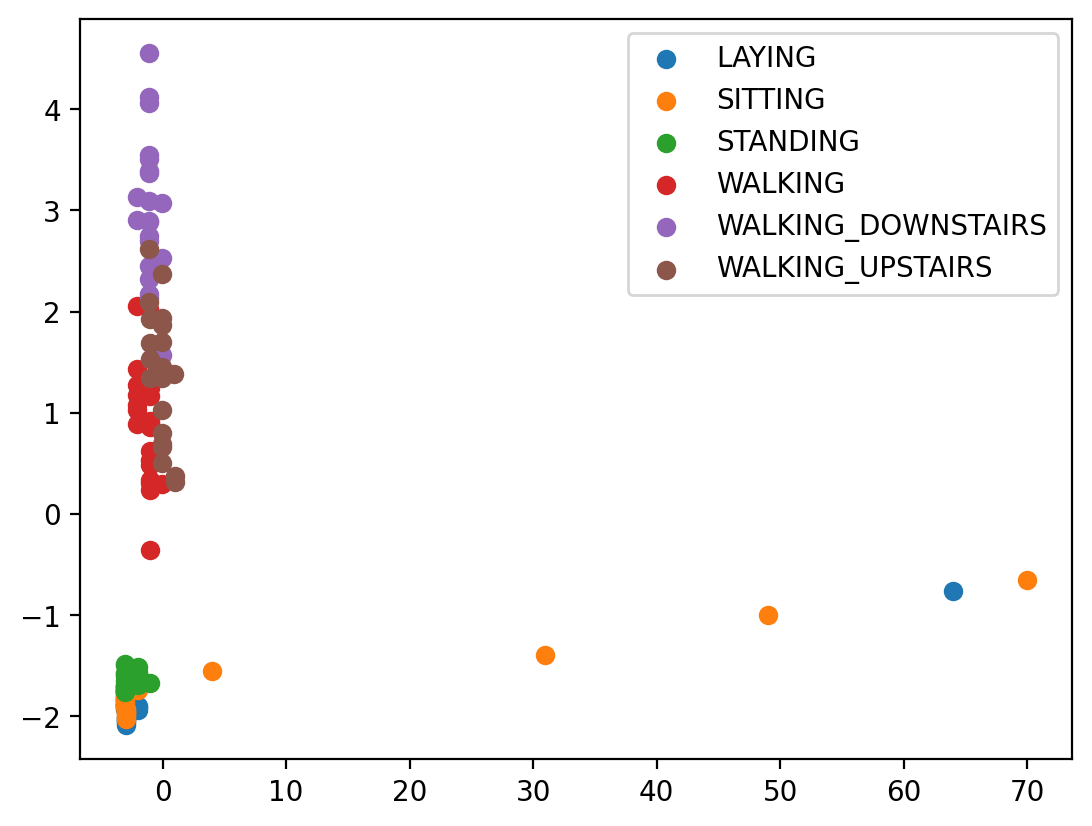

In [41]:
for i in range(len(activities)):
    activity = activities[i]
    plt.scatter(tsfel_pca_data[i*21:(i+1)*21,0],tsfel_pca_data[i*21:(i+1)*21,1],label=activity)
    plt.legend()

PCA on features provided in dataset

In [42]:
X_train_features = np.loadtxt('UCI HAR Dataset/train/X_train.txt')
X_train_features.shape

(7352, 561)

In [43]:
y_train_features = np.loadtxt('UCI HAR Dataset/train/y_train.txt')
y_train_features.shape

(7352,)

In [44]:
pca = PCA(n_components=2, random_state=42)
pca.fit(X_train_features)
X_train_pca_data = pca.transform(X_train_features)
X_train_pca_data.shape

(7352, 2)

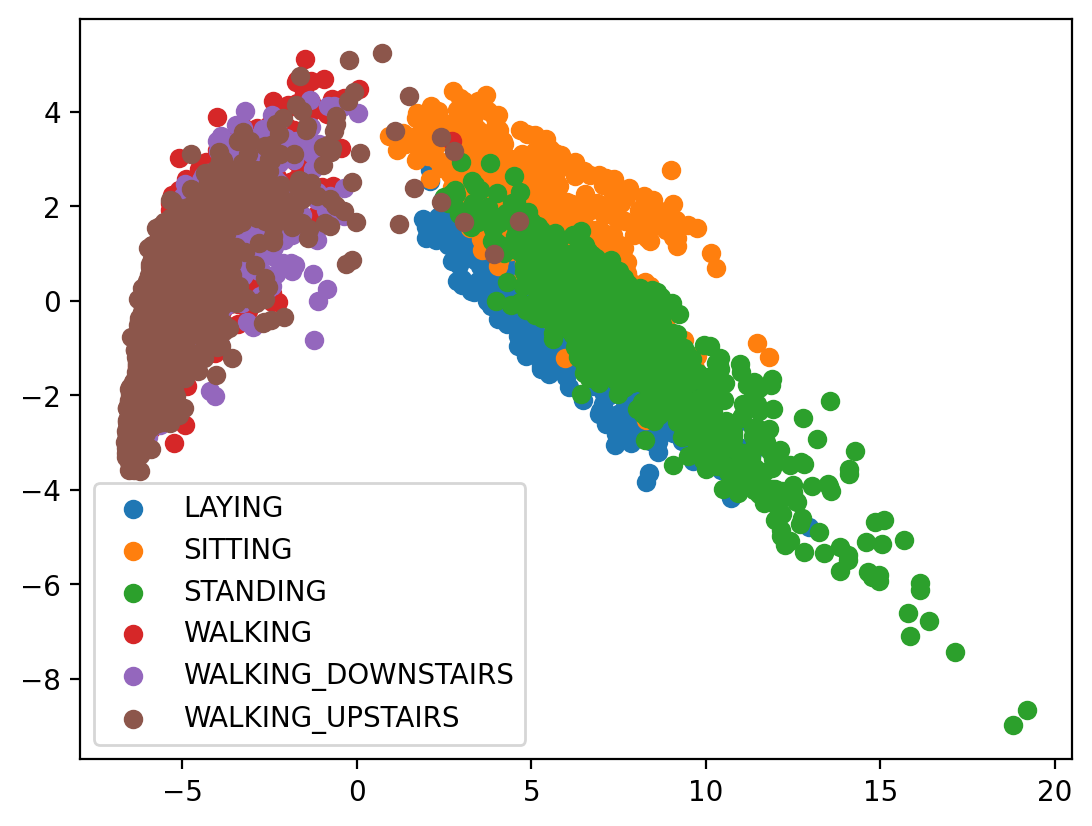

In [53]:
for i in range(1,7):
    plt.scatter(X_train_pca_data[y_train_features==i,0],X_train_pca_data[y_train_features==i,1],label=activities[i-1])
    plt.legend()

- The PCA on the total_acceleration is very scattered and the different activities have very high overlapping region in that graph.
- Whereas, the PCA on TSFEL featurized data and on features provided in the data have better plots as different activities can be clearly distinguished in different clusters with less overlap.
- Either of the TSFEL or dataset provided by the features is good for visualising the data.

### Q4 Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features? [1 marks]

In [48]:
os.listdir()
features = np.loadtxt('UCI HAR Dataset/features.txt',dtype=str)
features = features[:, 1]

In [49]:
tsfel_features_train_df = pd.DataFrame(tsfel_features_train,columns=['mean','var','dist','mad','corr','auc'])
dataset_features_train_df = pd.DataFrame(X_train_features,columns=features)

In [50]:
tsfel_features_train_df.corr()

,mean,var,dist,mad,corr,auc
mean,1.000000,0.906074,0.940925,0.963414,-0.091050,0.999958
var,0.906074,1.000000,0.908139,0.947084,-0.063738,0.906380
dist,0.940925,0.908139,1.000000,0.974450,-0.069124,0.941345
mad,0.963414,0.947084,0.974450,1.000000,-0.067565,0.963569
corr,-0.091050,-0.063738,-0.069124,-0.067565,1.000000,-0.091031
auc,0.999958,0.906380,0.941345,0.963569,-0.091031,1.000000


For TSFEL, all the features except the autocorrelation are highly correlated to each other. Autocorr is very less related to each of the others.
Therefore, some of mean, var, dist, mad and auc are redundant here.

In [51]:
dataset_features_train_df.corr()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
tBodyAcc-mean()-X,1.000000,0.148061,-0.256952,0.000619,-0.021903,-0.044617,0.006290,-0.022754,-0.047558,0.044062,...,0.030681,-0.017557,-0.015613,-0.544320,0.012173,0.037444,0.028844,-0.035257,0.034371,0.028242
tBodyAcc-mean()-Y,0.148061,1.000000,-0.078769,-0.045160,-0.044920,-0.049746,-0.044180,-0.045049,-0.050402,-0.038108,...,-0.022395,-0.001587,-0.004459,0.070559,-0.013541,0.017967,0.075679,-0.005309,0.001053,-0.013903
tBodyAcc-mean()-Z,-0.256952,-0.078769,1.000000,-0.020217,-0.016641,-0.008410,-0.018747,-0.015203,-0.001988,-0.037197,...,-0.020481,0.020091,0.019127,0.052841,-0.039836,-0.063609,-0.034037,0.008587,-0.015288,-0.022643
tBodyAcc-std()-X,0.000619,-0.045160,-0.020217,1.000000,0.927461,0.851668,0.998632,0.920888,0.846392,0.980844,...,-0.065987,0.148034,0.115565,-0.035011,-0.021633,0.018985,-0.024810,-0.371653,0.471065,0.394825
tBodyAcc-std()-Y,-0.021903,-0.044920,-0.016641,0.927461,1.000000,0.895510,0.922803,0.997347,0.894509,0.917366,...,-0.105621,0.206227,0.176946,-0.020379,-0.012505,-0.008507,-0.014592,-0.380531,0.523600,0.433169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"angle(tBodyGyroMean,gravityMean)",0.037444,0.017967,-0.063609,0.018985,-0.008507,-0.018429,0.019389,-0.012546,-0.023525,0.025066,...,-0.026615,0.034514,0.024553,-0.006269,0.009141,1.000000,-0.116001,-0.005853,-0.012313,-0.019903
"angle(tBodyGyroJerkMean,gravityMean)",0.028844,0.075679,-0.034037,-0.024810,-0.014592,-0.006471,-0.024951,-0.012341,-0.007231,-0.028871,...,0.000102,-0.017937,-0.014865,-0.020823,0.035263,-0.116001,1.000000,0.023995,-0.005869,-0.005656
"angle(X,gravityMean)",-0.035257,-0.005309,0.008587,-0.371653,-0.380531,-0.345011,-0.368191,-0.377025,-0.347389,-0.384192,...,0.087332,-0.086006,-0.079751,0.011880,0.023246,-0.005853,0.023995,1.000000,-0.783848,-0.643655
"angle(Y,gravityMean)",0.034371,0.001053,-0.015288,0.471065,0.523600,0.476006,0.466424,0.525081,0.477607,0.480229,...,-0.100125,0.086993,0.078079,0.001540,-0.012990,-0.012313,-0.005869,-0.783848,1.000000,0.594885
